In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problems.high_dimension_problems import MengCase1
from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
# fix the random seed for reproducibility
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# define function
func = MengCase1(noise_std=0.0)
# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
# hf_samples = lf_samples[::10]  # sample every 5 points
hf_samples= torch.linspace(0.1, 0.9, 15).reshape(-1, 1)

# generate responses
lf1_responses = func.lf1(lf_samples,  noise_lf=0.05)
lf2_responses = func.lf2(lf_samples, noise_lf=0.05)
lf3_responses = func.lf3(lf_samples, noise_lf=0.05)
# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.05)

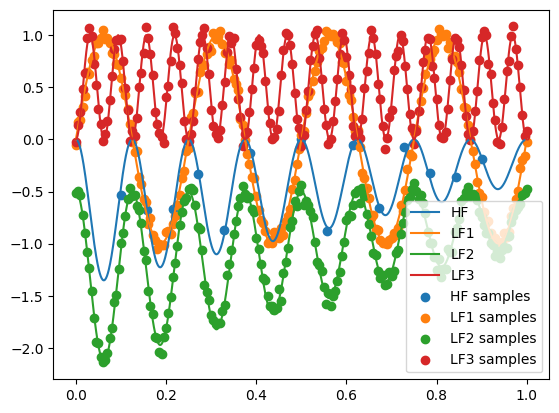

In [3]:
# generate the test points
test_samples = torch.linspace(0, 1, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf1_responses_noiseless = func.lf1(test_samples, noise_lf=0.0)
test_lf2_responses_noiseless = func.lf2(test_samples, noise_lf=0.0)
test_lf3_responses_noiseless = func.lf3(test_samples, noise_lf=0.0)
# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.05)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf1_responses_noiseless, label="LF1")
ax.plot(test_samples, test_lf2_responses_noiseless, label="LF2")
ax.plot(test_samples, test_lf3_responses_noiseless, label="LF3")

# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf1_responses, label="LF1 samples")
ax.scatter(lf_samples, lf2_responses, label="LF2 samples")
ax.scatter(lf_samples, lf3_responses, label="LF3 samples")
plt.legend()
plt.show()

In [4]:
# correlation between HF and LF samples
print("Correlation between HF and LF samples")
print(pearsonr(test_hf_responses_noiseless.flatten(), test_lf1_responses_noiseless.flatten()))
print(pearsonr(test_hf_responses_noiseless.flatten(), test_lf2_responses_noiseless.flatten()))
print(pearsonr(test_hf_responses_noiseless.flatten(), test_lf3_responses_noiseless.flatten()))


Correlation between HF and LF samples
PearsonRResult(statistic=-0.10188648995412593, pvalue=0.0012469388228371753)
PearsonRResult(statistic=0.9999999999999967, pvalue=0.0)
PearsonRResult(statistic=-0.0017524227898377388, pvalue=0.9558397582437065)


## Configurations for DNN and BNNs


In [5]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

responses = {"lf": lf3_responses, "hf": hf_responses}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 20000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 20000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 10000,
}

### train standard BNN using HF data


In [6]:
# the pretrained model path
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses - hf_responses_mean) / hf_responses_std

# create the sf_bnn model
sigma_scale = float(0.05 / hf_responses_std)
bnn_model =BNNWrapper(
    in_features=1,
    hidden_features=[50, 50],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)
# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses_scaled,
    num_epochs=20000,
    sample_freq=100,
    burn_in_epochs=10000,
)


epoch:     0/20000
nll_loss: 283.503, prior_loss: 2508.368, total: 2791.872
noise: 0.157


/home/yaga/Documents/GitHub/mfbml/src/mfbml/methods/bnn.py:170: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:   100/20000
nll_loss: 227.514, prior_loss: 2667.355, total: 2894.869
noise: 0.157
epoch:   200/20000
nll_loss: 226.850, prior_loss: 2767.472, total: 2994.322
noise: 0.157
epoch:   300/20000
nll_loss: 226.198, prior_loss: 2861.910, total: 3088.108
noise: 0.157
epoch:   400/20000
nll_loss: 226.314, prior_loss: 2964.484, total: 3190.798
noise: 0.157
epoch:   500/20000
nll_loss: 228.840, prior_loss: 3061.099, total: 3289.939
noise: 0.157
epoch:   600/20000
nll_loss: 227.413, prior_loss: 3141.607, total: 3369.020
noise: 0.157
epoch:   700/20000
nll_loss: 227.669, prior_loss: 3207.642, total: 3435.311
noise: 0.157
epoch:   800/20000
nll_loss: 227.671, prior_loss: 3283.611, total: 3511.282
noise: 0.157
epoch:   900/20000
nll_loss: 226.897, prior_loss: 3346.434, total: 3573.332
noise: 0.157
epoch:  1000/20000
nll_loss: 226.228, prior_loss: 3417.221, total: 3643.450
noise: 0.157
epoch:  1100/20000
nll_loss: 227.647, prior_loss: 3474.880, total: 3702.527
noise: 0.157
epoch:  1200/20000
nl

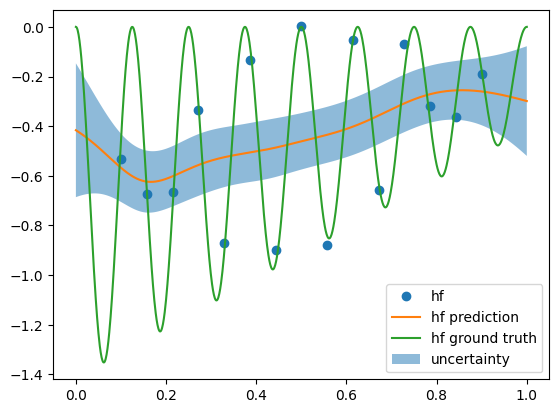

In [7]:
# visualize the posterior of bnn
bnn_y, bnn_epistemic, bnn_total_unc, bnn_aleatoric = bnn_model.predict(
    x=test_samples)
# scale the prediction 
bnn_y = bnn_y * hf_responses.std().numpy() + hf_responses.mean().numpy()
bnn_total_unc = bnn_total_unc * hf_responses.std().numpy()
bnn_epistemic = bnn_epistemic * hf_responses.std().numpy()
bnn_aleatoric = bnn_aleatoric * hf_responses.std().numpy()

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")
plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
plt.legend()
plt.show()

# training of sequential MF-DNN-BNN model


In [8]:
# sequential mf-bnn
smf_bnn_lf1 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)
# train the model
responses_lf1 = {"lf": lf1_responses, 
                 "hf": hf_responses}
smf_bnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)
# save the model
torch.save(smf_bnn_lf1, "smf_bnn_lf1.pth")

No data split: use all data for training
epoch:  100 train loss:  0.9607730507850647
epoch:  200 train loss:  0.9599181413650513
epoch:  300 train loss:  0.9577919840812683
epoch:  400 train loss:  0.9400203824043274
epoch:  500 train loss:  0.8709079623222351
epoch:  600 train loss:  0.7274209260940552
epoch:  700 train loss:  0.41053831577301025
epoch:  800 train loss:  0.1405869722366333
epoch:  900 train loss:  0.061873216181993484
epoch:  1000 train loss:  0.023264054208993912
epoch:  1100 train loss:  0.014054931700229645
epoch:  1200 train loss:  0.009157081134617329
epoch:  1300 train loss:  0.006671298295259476
epoch:  1400 train loss:  0.005486870184540749
epoch:  1500 train loss:  0.004902647342532873
epoch:  1600 train loss:  0.004581323824822903
epoch:  1700 train loss:  0.004387243185192347
epoch:  1800 train loss:  0.004247013479471207
epoch:  1900 train loss:  0.004145497921854258
epoch:  2000 train loss:  0.00406720070168376
epoch:  2100 train loss:  0.0040035806596279

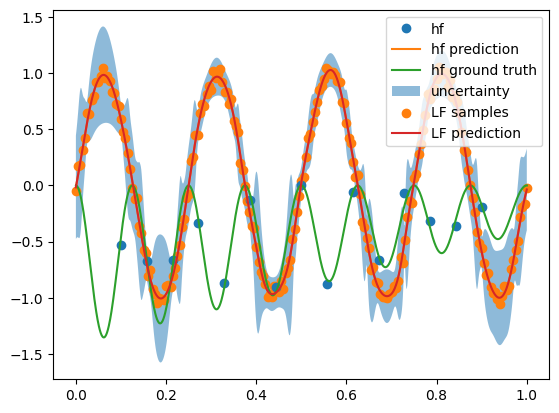

In [14]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf1_y,
    smf_bnn_lf1_epistemic,
    smf_bnn_lf1_total_unc,
    smf_bnn_lf1_aleatoric,
) = smf_bnn_lf1.predict(x=test_samples)
# get lf predictions
smf_bnn_lf1_y =  smf_bnn_lf1.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf1_y, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_y - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_y + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [ ]:
# create the MFDNNBNN object
mfdnnbnn = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

In [ ]:

(
    y_proposed,
    epistemic_proposed,
    total_unc_proposed,
    aleatoric_proposed,
) = mfdnnbnn.predict(x=test_samples)
# lf prediction
lf_y_proposed = mfdnnbnn.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [ ]:
mfdnnbnn.beta

In [ ]:
print("=====================================")
print("BNN")
nrmse_bnn = normalized_rmse(test_hf_responses_noiseless.numpy(),
                            bnn_y)
print("nrmse: ", nrmse_bnn)
nmae_bnn = normalized_mae(test_hf_responses_noiseless.numpy(),
                          bnn_y)
print("nmae: ", nmae_bnn)
ll_bnn = mean_log_likelihood_value(
    test_hf_responses.numpy(),
    bnn_y,
    bnn_total_unc)
print("ll_bnn: ", ll_bnn)
# r2 score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(),
                        bnn_y))
# sequential mf-bnn
print("=====================================")
print("Sequential MF-BNN")
nrmse_sequential_bnn = normalized_rmse(
    test_hf_responses_noiseless.numpy(),
    sequential_bnn_y
)
print("nrmse: ", nrmse_sequential_bnn)
nmae_sequential_bnn = normalized_mae(
    test_hf_responses_noiseless.numpy(),
    sequential_bnn_y
)
print("nmae: ", nmae_sequential_bnn)
ll_sequential_bnn = mean_log_likelihood_value(
    test_hf_responses.numpy(),
    sequential_bnn_y,
    sequential_bnn_total_unc,
)
print("ll_sequential_bnn: ", ll_sequential_bnn)
# R2 Score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(),
                        sequential_bnn_y))
# MFDNNBNN
print("=====================================")
print("MFDNNBNN")
nrmse_mfdnnbnn = normalized_rmse(
    test_hf_responses_noiseless.numpy(),
    y_proposed)
print("nrmse: ", nrmse_mfdnnbnn)
nmae_mfdnnbnn = normalized_mae(test_hf_responses_noiseless.numpy(),
                               y_proposed)
print("nmae: ", nmae_mfdnnbnn)
ll_mfdnnbnn = mean_log_likelihood_value(
    test_hf_responses.numpy(),
    y_proposed,
    total_unc_proposed
)
print("ll_mfdnnbnn: ", ll_mfdnnbnn)
# R2 Score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(),
                        y_proposed))

In [ ]:
font_size = 16
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

# plot results of bnn
ax[0].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[0].plot(
    test_samples.numpy(),
    bnn_y,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)
ax[0].fill_between(
    test_samples.flatten(),
    (bnn_y - 2 * bnn_total_unc).flatten(),
    (bnn_y + 2 * bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# ax[0].legend(loc="lower right")
ax[0].set_title("BNN", fontsize=font_size)
ax[0].set_xlabel("x", fontsize=font_size)
ax[0].set_ylabel("y", fontsize=font_size)
ax[0].tick_params(labelsize=font_size)
# ax[0].set_ylim([-2, 1.0])

#  plot for sequential mf-bnn
ax[1].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF noiseless truth",
)
ax[1].plot(
    test_samples.numpy(),
    sequential_bnn_y,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)

ax[1].fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).flatten(),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# ax[1].legend(loc="lower right")
ax[1].set_title("Concatenate MF-BNN", fontsize=font_size)
ax[1].set_xlabel("x", fontsize=font_size)
ax[1].set_ylabel(" ", fontsize=font_size)
ax[1].tick_params(labelsize=font_size)
# ax[1].set_ylim([-2, 1.0])

# plot for MFDNNBNN
ax[2].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[2].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)

ax[2].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).flatten(),
    (y_proposed + 2 * total_unc_proposed).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax[2].set_title("MF-DNN-BNN", fontsize=font_size)
ax[2].set_xlabel("x", fontsize=font_size)
ax[2].set_ylabel(" ", fontsize=font_size)
ax[2].tick_params(labelsize=font_size)
# ax[2].set_ylim([-2, 1.0])
# ax[2].legend(loc="lower right")
plt.legend(loc="upper center", bbox_to_anchor=(-0.7, 1.25),
           ncol=4, fontsize=12.5)

# set the font size of axis
for i in range(3):
    ax[i].tick_params(axis="both", which="major", labelsize=14)
    # set the line width of the axis
    for axis in ["top", "bottom", "left", "right"]:
        ax[i].spines[axis].set_linewidth(1.5)

plt.savefig("mf_dnn_bnn_known_noise.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise.svg", dpi=300, bbox_inches="tight")
plt.show()